# Spark SQL

Spark SQL allows one to query structured data in Spark applications. It supports 2 query parsers: SQL and HiveQL.
We will focus on SQL in the following. Spark SQL and dataframes are often used as synonyms.

## Spark DataFrames with Python
This notebook demonstrates a number of common Spark DataFrames functions using Python.

In [1]:
# import pyspark class Row from module sql
from pyspark.sql import *
# Create Example Data - Departments and Employees

# Create the Departments
department1 = Row(id='123456', name='Computer Science')
department2 = Row(id='789012', name='Mechanical Engineering')
department3 = Row(id='345678', name='Theater and Drama')
department4 = Row(id='901234', name='Indoor Recreation')

# Create the Employees
Employee = Row("firstName", "lastName", "email", "salary")
employee1 = Employee('michael', 'armbrust', 'no-reply@berkeley.edu', 100000)
employee2 = Employee('xiangrui', 'meng', 'no-reply@stanford.edu', 120000)
employee3 = Employee('matei', None, 'no-reply@waterloo.edu', 140000)
employee4 = Employee(None, 'wendell', 'no-reply@berkeley.edu', 160000)

# Create the DepartmentWithEmployees instances from Departments and Employees
departmentWithEmployees1 = Row(department=department1, employees=[employee1, employee2])
departmentWithEmployees2 = Row(department=department2, employees=[employee3, employee4])
departmentWithEmployees3 = Row(department=department3, employees=[employee1, employee4])
departmentWithEmployees4 = Row(department=department4, employees=[employee2, employee3])

print department1
print employee2
print departmentWithEmployees1.employees[0].email

Row(id='123456', name='Computer Science')
Row(firstName='xiangrui', lastName='meng', email='no-reply@stanford.edu', salary=120000)
no-reply@berkeley.edu


Create the first DataFrame from a list of the rows.

In [2]:
departmentsWithEmployeesSeq1 = [departmentWithEmployees1, departmentWithEmployees2]
df1 = spark.createDataFrame(departmentsWithEmployeesSeq1)
df1.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|[123456,Computer ...|[[michael,armbrus...|
|[789012,Mechanica...|[[matei,null,no-r...|
+--------------------+--------------------+



Create a 2nd DataFrame from a list of rows.

In [3]:
departmentsWithEmployeesSeq2 = [departmentWithEmployees3, departmentWithEmployees4]
df2 = spark.createDataFrame(departmentsWithEmployeesSeq2)
df2.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|[345678,Theater a...|[[michael,armbrus...|
|[901234,Indoor Re...|[[xiangrui,meng,n...|
+--------------------+--------------------+



### Working with DataFrames

Union to DataFrames.

In [4]:
unionDF = df1.unionAll(df2)
unionDF.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|[123456,Computer ...|[[michael,armbrus...|
|[789012,Mechanica...|[[matei,null,no-r...|
|[345678,Theater a...|[[michael,armbrus...|
|[901234,Indoor Re...|[[xiangrui,meng,n...|
+--------------------+--------------------+



Write the Unioned DataFrame to a Parquet file.

In [5]:
# we will define this utility function once again inline here
def output_cleaner():
    import os
    os.system("rm -rf ./output*")
    print "Output folders removed!"

In [6]:
#clean tmp directories if necessary
output_cleaner()

Output folders removed!


In [7]:
unionDF.write.parquet("./output_parquet/dfexample_parquet")

Read a DataFrame from the Parquet file.

In [8]:
parquetDF = spark.read.parquet("./output_parquet/dfexample_parquet")
parquetDF.show()

+--------------------+--------------------+
|          department|           employees|
+--------------------+--------------------+
|[345678,Theater a...|[[michael,armbrus...|
|[123456,Computer ...|[[michael,armbrus...|
|[789012,Mechanica...|[[matei,null,no-r...|
|[901234,Indoor Re...|[[xiangrui,meng,n...|
+--------------------+--------------------+



### Explode Function:

Explode the employees column.

https://spark.apache.org/docs/latest/api/python/_modules/pyspark/sql/functions.html#explode

```python
def explode(col):
    """Returns a new row for each element in the given array or map.

    >>> from pyspark.sql import Row
    >>> eDF = spark.createDataFrame([Row(a=1, intlist=[1,2,3], mapfield={"a": "b"})])
    >>> eDF.select(explode(eDF.intlist).alias("anInt")).collect()
    [Row(anInt=1), Row(anInt=2), Row(anInt=3)]

    >>> eDF.select(explode(eDF.mapfield).alias("key", "value")).show()
    +---+-----+
    |key|value|
    +---+-----+
    |  a|    b|
    +---+-----+
    """
```

In [9]:
from pyspark.sql.functions import explode

df = parquetDF.select(explode("employees").alias("e"))
explodeDF = df.selectExpr("e.firstName", "e.lastName", "e.email", "e.salary")
explodeDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|     null| wendell|no-reply@berkeley...|160000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
|     null| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



In [10]:
explodeDF

DataFrame[firstName: string, lastName: string, email: string, salary: bigint]

In [11]:
filterDF = explodeDF.filter(explodeDF.firstName == "xiangrui").sort(explodeDF.lastName)
filterDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



In [12]:
from pyspark.sql.functions import col, asc

# Use `|` instead of `or` 
filterDF = explodeDF.filter((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
filterDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



The where() clause is equivalent to filter().

In [13]:
whereDF = explodeDF.where((col("firstName") == "xiangrui") | (col("firstName") == "michael")).sort(asc("lastName"))
whereDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
| xiangrui|    meng|no-reply@stanford...|120000|
+---------+--------+--------------------+------+



Replace null values with -- using DataFrame Na functions.

In [14]:
nonNullDF = explodeDF.fillna("--")
nonNullDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|  michael|armbrust|no-reply@berkeley...|100000|
|       --| wendell|no-reply@berkeley...|160000|
|  michael|armbrust|no-reply@berkeley...|100000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
|       --| wendell|no-reply@berkeley...|160000|
| xiangrui|    meng|no-reply@stanford...|120000|
|    matei|      --|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



Retrieve only rows with missing firstName or lastName.

In [15]:
filterNonNullDF = explodeDF.filter(col("firstName").isNull() | col("lastName").isNull()).sort("email")
filterNonNullDF.show()

+---------+--------+--------------------+------+
|firstName|lastName|               email|salary|
+---------+--------+--------------------+------+
|     null| wendell|no-reply@berkeley...|160000|
|     null| wendell|no-reply@berkeley...|160000|
|    matei|    null|no-reply@waterloo...|140000|
|    matei|    null|no-reply@waterloo...|140000|
+---------+--------+--------------------+------+



Example aggregations using agg() and countDistinct().

In [16]:
from pyspark.sql.functions import countDistinct

countDistinctDF = explodeDF.select("firstName", "lastName")\
  .groupBy("firstName", "lastName").agg(countDistinct("firstName"))

countDistinctDF.show()

+---------+--------+-------------------------+
|firstName|lastName|count(DISTINCT firstName)|
+---------+--------+-------------------------+
|     null| wendell|                        0|
|    matei|    null|                        1|
| xiangrui|    meng|                        1|
|  michael|armbrust|                        1|
+---------+--------+-------------------------+



Compare the DataFrame and SQL Query Physical Plans (Hint: They should be the same.)

In [17]:
countDistinctDF.explain()

== Physical Plan ==
*HashAggregate(keys=[firstName#60, lastName#61], functions=[count(distinct firstName#60)])
+- *HashAggregate(keys=[firstName#60, lastName#61], functions=[partial_count(distinct firstName#60)])
   +- *HashAggregate(keys=[firstName#60, lastName#61, firstName#60], functions=[])
      +- Exchange hashpartitioning(firstName#60, lastName#61, firstName#60, 200)
         +- *HashAggregate(keys=[firstName#60, lastName#61, firstName#60], functions=[])
            +- *Project [e#57.firstName AS firstName#60, e#57.lastName AS lastName#61]
               +- Generate explode(employees#32), false, false, [e#57]
                  +- *FileScan parquet [employees#32] Batched: false, Format: Parquet, Location: InMemoryFileIndex[file:/Users/alexey/Desktop/BigDataCourse/3_DataFramesSQL/output_parquet/dfexamp..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<employees:array<struct<firstName:string,lastName:string,email:string,salary:bigint>>>


In [18]:
# register the DataFrame as a temp table so that we can query it using SQL
explodeDF.registerTempTable("df_example")

# Perform the same query as the DataFrame above and return ``explain``
countDistinctDF_sql = spark.sql("SELECT firstName, lastName, count(distinct firstName) as distinct_first_names FROM df_example GROUP BY firstName, lastName")

countDistinctDF_sql.explain()

== Physical Plan ==
*HashAggregate(keys=[firstName#60, lastName#61], functions=[count(distinct firstName#60)])
+- *HashAggregate(keys=[firstName#60, lastName#61], functions=[partial_count(distinct firstName#60)])
   +- *HashAggregate(keys=[firstName#60, lastName#61, firstName#60], functions=[])
      +- Exchange hashpartitioning(firstName#60, lastName#61, firstName#60, 200)
         +- *HashAggregate(keys=[firstName#60, lastName#61, firstName#60], functions=[])
            +- *Project [e#57.firstName AS firstName#60, e#57.lastName AS lastName#61]
               +- Generate explode(employees#32), false, false, [e#57]
                  +- *FileScan parquet [employees#32] Batched: false, Format: Parquet, Location: InMemoryFileIndex[file:/Users/alexey/Desktop/BigDataCourse/3_DataFramesSQL/output_parquet/dfexamp..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<employees:array<struct<firstName:string,lastName:string,email:string,salary:bigint>>>


Sum up all the salaries

In [19]:
salarySumDF = explodeDF.agg({"salary" : "sum"}) 
salarySumDF.show()

+-----------+
|sum(salary)|
+-----------+
|    1040000|
+-----------+



In [20]:
type(explodeDF.salary)

pyspark.sql.column.Column

Print the summary statistics for the salaries.

In [21]:
explodeDF.describe("salary").show()

+-------+------------------+
|summary|            salary|
+-------+------------------+
|  count|                 8|
|   mean|          130000.0|
| stddev|23904.572186687874|
|    min|            100000|
|    max|            160000|
+-------+------------------+



### An example using Pandas & Matplotlib Integration

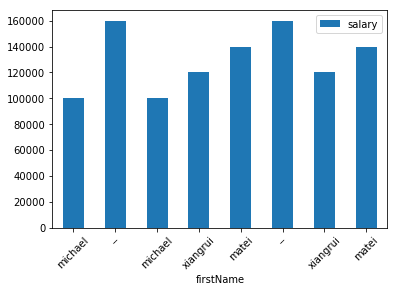

In [27]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

plt.clf()
pdDF = nonNullDF.toPandas()
pdDF.plot(x='firstName', y='salary', kind='bar', rot=45)
#display()

## User Defined Functions in Python

This notebook contains an examples of creating a UDF in Python and registering it for use in Spark SQL.


#### Step 1: Register a function as a UDF.

After the standard function is defined in Python, you need to register it as a UDF to be able to use on Spark DataFrames

In [28]:
def squared(s):
    return s * s

spark.udf.register("squaredWithPython", squared)

Optionally, you can also explicitly set the return type of your UDF.

In [29]:
from pyspark.sql.types import LongType
def squared_typed(s):
    return s * s

sqlContext.udf.register("squaredWithPython", squared, LongType())

#### Step 2: Call the UDF in Spark SQL.

In [30]:
sqlContext.range(1, 20).registerTempTable("test")

#### Step 3: Use UDF with DataFrames

In [31]:
from pyspark.sql.functions import udf

squared_udf = udf(squared, LongType())
df = spark.table("test")
df.select("id", squared_udf("id").alias("id_squared")).show()

+---+----------+
| id|id_squared|
+---+----------+
|  1|         1|
|  2|         4|
|  3|         9|
|  4|        16|
|  5|        25|
|  6|        36|
|  7|        49|
|  8|        64|
|  9|        81|
| 10|       100|
| 11|       121|
| 12|       144|
| 13|       169|
| 14|       196|
| 15|       225|
| 16|       256|
| 17|       289|
| 18|       324|
| 19|       361|
+---+----------+

